In [253]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import mean_squared_error

### Loading and Preparing the Data

In [254]:
time = pd.read_csv('./data/aggregated_experiments.csv')
time = time[['dataset', 'relative_loading_speed', 'count']]
time = time.rename(columns={'count': 'batch'})

In [255]:
stats = pd.read_csv('./statistics.csv')

# Calculating a few additional statistics based on those already present
stats['object_count'] = stats['literal_object_count'] + stats['entity_object_count']
stats['str_ratio'] = stats['str_count'] / stats['object_count']
stats['numerical_ratio'] = stats['numerical_like_count'] / stats['object_count']
stats['date_ratio'] = stats['date_like_count'] / stats['object_count']

In [256]:
df = pd.merge(stats, time, on='dataset')
df_only_stats = df.drop(columns=['dataset'])

### Correlation

<Axes: >

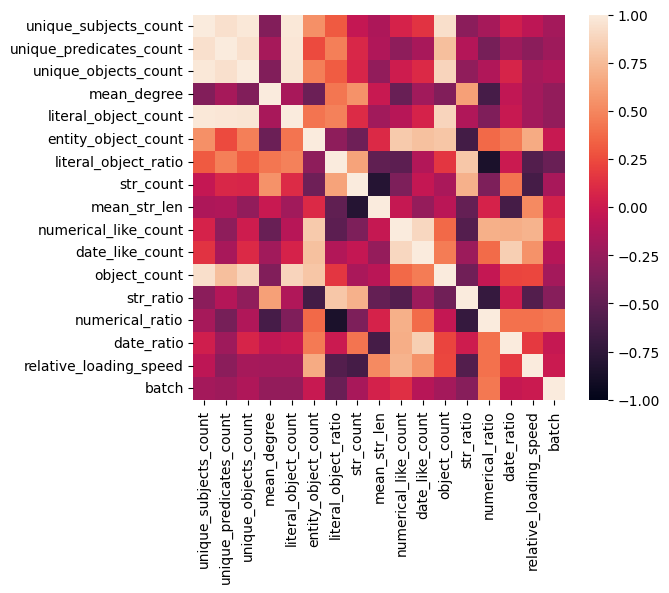

In [72]:
plt.figure(figsize=(6, 5))
sns.heatmap(df_only_stats.corr(), annot=False, fmt='.1f', vmin=-1, vmax=1)

At first glance it seems that the number of unique subjects, predicates and objects is highly correlated.
However it is clear that `dbpedia-live` is an outlier that messes with the correlation.

<Axes: xlabel='unique_subjects_count', ylabel='unique_predicates_count'>

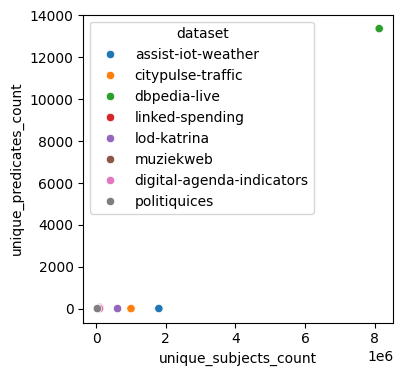

In [28]:
plt.figure(figsize=(4,4))
sns.scatterplot(data=df, x='unique_subjects_count', y='unique_predicates_count', hue='dataset')

With it removed, there doesn't seem to be any correlation.

<Axes: xlabel='unique_subjects_count', ylabel='unique_predicates_count'>

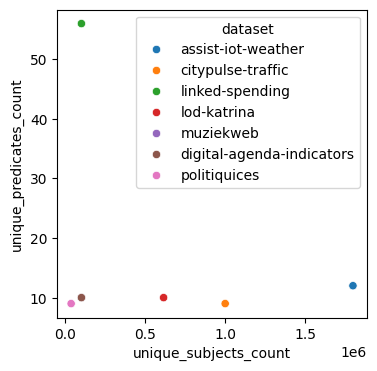

In [29]:
plt.figure(figsize=(4,4))
sns.scatterplot(data=df[df['dataset'] != 'dbpedia-live'], x='unique_subjects_count', y='unique_predicates_count', hue='dataset')

The correlation does seem to be true for `unique_subjects_count` vs. `unique_objects_count`

<Axes: xlabel='unique_subjects_count', ylabel='unique_objects_count'>

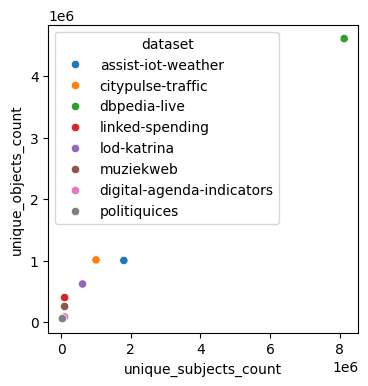

In [30]:
plt.figure(figsize=(4,4))
sns.scatterplot(data=df, x='unique_subjects_count', y='unique_objects_count', hue='dataset')

With `dbpedia-live` removed the correlation matrix looks quite different. 
Most notably `unique_subject_count` and `unique_object_count` are highly correlated with a few different attributes.

<Axes: >

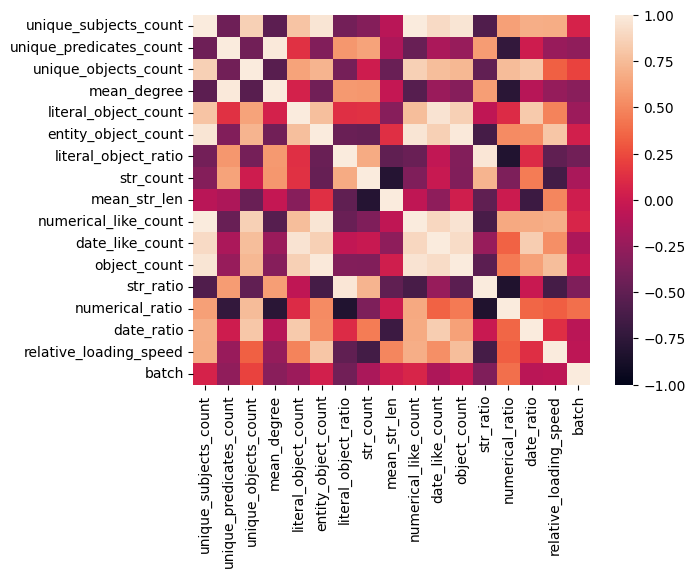

In [73]:
sns.heatmap(df[df['dataset'] != 'dbpedia-live'].drop(columns=['dataset']).corr(), annot=False, fmt='.1f', vmin=-1, vmax=1)

Some attributes are calculated using a combination of others so we will remove some columns which we can assume will be correlated with others in someway to make it easier to further analyse the rest of the correlations.

In [257]:
df = df.drop(columns=[
    'unique_predicates_count',  # highly correlated with mean_degree
    'unique_objects_count',     # highly correlated with unique_subjects count
    'literal_object_count',     # highly correlated with unique_objects count
    'entity_object_count',      # highly correlated with unique_objects count
    'numerical_like_count',     # highly correlated with unique_objects count
    'str_count',                # highly correlated with unique_objects count
    'date_like_count',          # highly correlated with unique_objects count
    'object_count',             # highly correlated with unique_objects count
    'literal_object_ratio',     # highly inversly correlated with few other ratios and attributes
    ])
df_only_stats = df.drop(columns=['dataset'])

<Axes: >

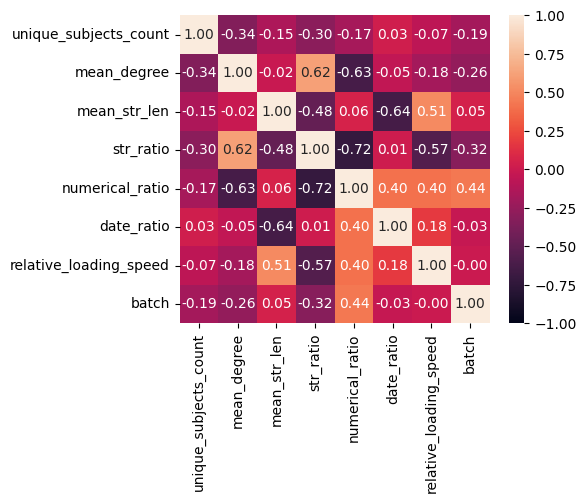

In [75]:
plt.figure(figsize=(5, 4))
sns.heatmap(df_only_stats.corr(), annot=True, fmt='.2f', vmin=-1, vmax=1)

Some attributes are still somewhat correlated but for now let's leave it as is, `str_ratio` and `numerical_ratio` will obviously be inversly correlated but both can be useful in their own ways.

### Training Data Preparation

We will apply a standard scaler on the training data as the values can get quite large and it will interfere with linear models such as linear regression.

In [258]:
def get_training_data(df):
    X = df.drop(columns=["relative_loading_speed", "dataset"])

    ss = StandardScaler() 
    X = ss.fit_transform(X)
    X = pd.DataFrame(columns=ss.get_feature_names_out(), data=X)

    y = df[["relative_loading_speed"]].values.flatten()

    return X, y

In [259]:
X, y = get_training_data(df)

### Linear Regression

The first model we will test is simple linear regression. We will try to predict the relative loading speed for each batch.
We will also use the batch number itself as a feature to account for the change in loading speed over time.

In [158]:
def evaluate_model(regressor, X):
    regressor.fit(X, y)
    y_pred = regressor.predict(X)
    predictions_df = pd.DataFrame(data={
        'speed': y,
        'speed_predicted': y_pred,
        'dataset': time['dataset']
    })
    mse = mean_squared_error(y, y_pred)
    return y_pred, predictions_df, mse

MSE: 0.04532393234351318


<Axes: xlabel='speed', ylabel='speed_predicted'>

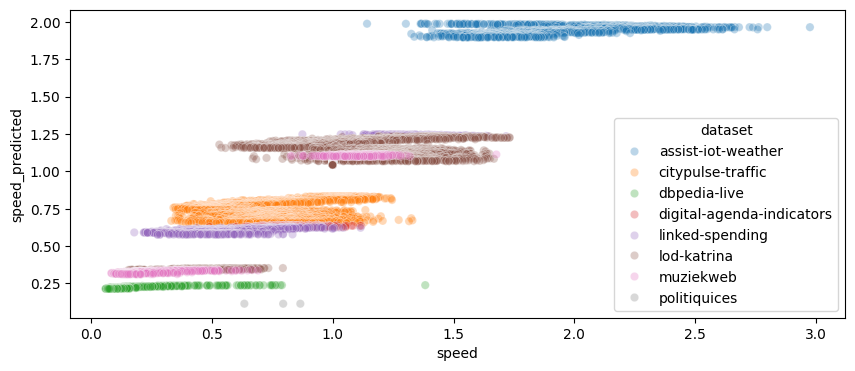

In [ ]:
linear_regression = LinearRegression()
y_pred, predictions_df, mse = evaluate_model(linear_regression, X)
print(f"MSE: {mse}")

plt.figure(figsize=(10, 4))
sns.scatterplot(data=predictions_df, x='speed', y='speed_predicted', hue='dataset', alpha=0.3)

Despite a relatively low MSE, the model isn't able to reliably predict the loading speed.
We have also tested adding polynomial features but the resulting model was only marginally better. For brevity these experiments are omitted in this notebook.

### RandomForrest

RandomForrest is one the best model to use when one wants to obtain features importances in a given dataset. It is also generally a much better model than LinearRegression so we will use it next.

MSE: 0.00191486238541323


<Axes: xlabel='speed', ylabel='speed_predicted'>

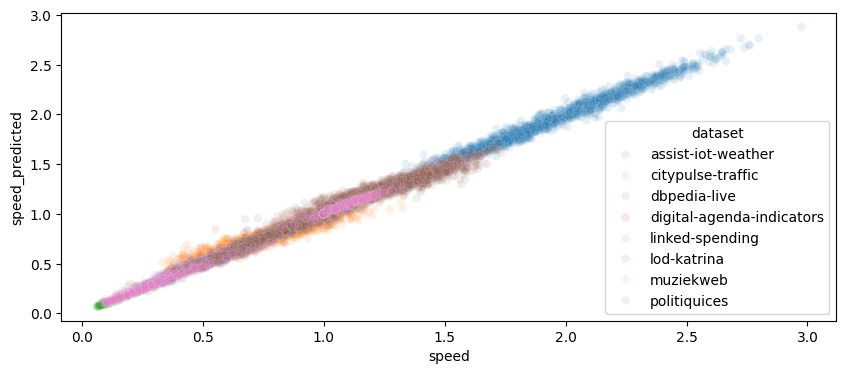

In [ ]:
rf = RandomForestRegressor()
y_pred, predictions_df, mse = evaluate_model(rf, X)
print(f"MSE: {mse}")

plt.figure(figsize=(10, 4))
sns.scatterplot(data=predictions_df, x='speed', y='speed_predicted', hue='dataset', alpha=0.1)

This model not only has a much better performance, it is also actually reasonably good at predicting the loading speeds.

Let's train a larger forest and extract the feature importances

In [ ]:
def get_feature_importances(rf, X):
    rf.fit(X, y)

    importance_df = pd.DataFrame(
        index=rf.feature_names_in_, 
        data={'importance': rf.feature_importances_}
    ).sort_values(by='importance', ascending=False)
    importance_df['relative'] = importance_df['importance'] / (1 / len(importance_df))
    importance_df

    return rf, importance_df

In [ ]:
rf = RandomForestRegressor(n_estimators=1000)
rf, importance_df = importance_df = get_feature_importances(rf, X)
importance_df

,importance,relative
str_ratio,0.717036,5.019253
batch,0.162379,1.136652
mean_str_len,0.058498,0.409487
date_ratio,0.053735,0.376143
mean_degree,0.002994,0.020955
unique_subjects_count,0.002754,0.019277
numerical_ratio,0.002605,0.018233


It seems that `str_ratio` is by far the greatest indicator of the loading speed. `batch` is also a relatively good indicator but it is expected to be one as it directly correlates to the loading speed over time.

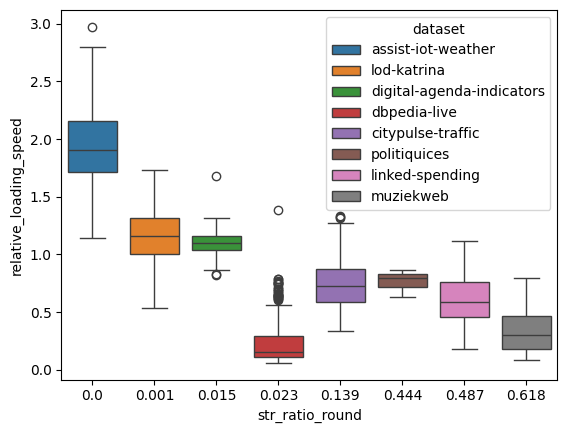

In [260]:
df['str_ratio_round'] = np.round(df['str_ratio'], 3) # tbh this is the fastest and easiest way to reliably round the tick values
ax = sns.boxplot(data=df.sort_values(by='str_ratio_round'), x='str_ratio_round', y='relative_loading_speed', hue='dataset')
df = df.drop(columns=['str_ratio_round'])
plt.show()

`mean_str_len` is also a somewhat important attribute, let's see how well it correlates with the loading speed

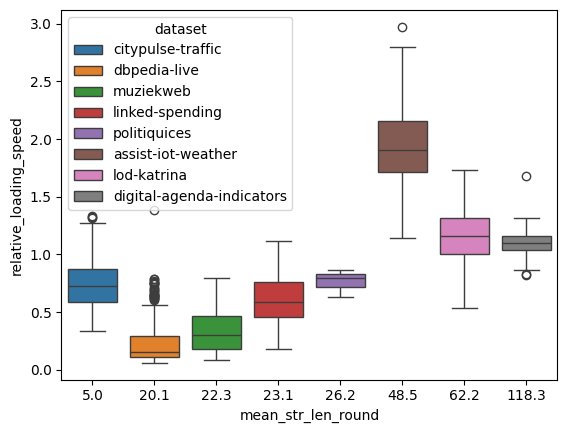

In [ ]:
df['mean_str_len_round'] = np.round(df['mean_str_len'], 1)
ax = sns.boxplot(data=df.sort_values(by='mean_str_len_round'), x='mean_str_len_round', y='relative_loading_speed', hue='dataset')
df = df.drop(columns=['mean_str_len_round'])
plt.show()

Let's see how a total length of all strings in a given datasets correlates with the loading speeds

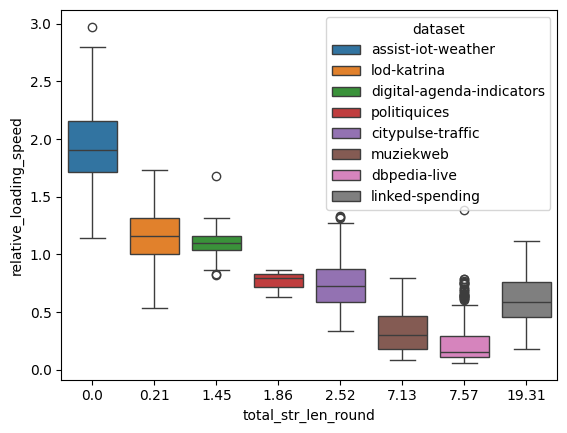

In [318]:
tmp_df = pd.merge(stats, time, on='dataset')
tmp_df['total_str_len'] = tmp_df['str_count'] * tmp_df['mean_str_len']

tmp_df['total_str_len_round'] = np.round(tmp_df['total_str_len'] / 1000000, 2)
ax = sns.boxplot(data=tmp_df.sort_values(by='total_str_len'), x='total_str_len_round', y='relative_loading_speed', hue='dataset')
plt.show()

It does in fact seem to be a highly correlated indicator. The only exception is `dbpedia-live` which has a low relative loading speed but a comparatively high `str_ratio`. The boxplot however skews the scale.

<Axes: xlabel='total_str_len', ylabel='relative_loading_speed'>

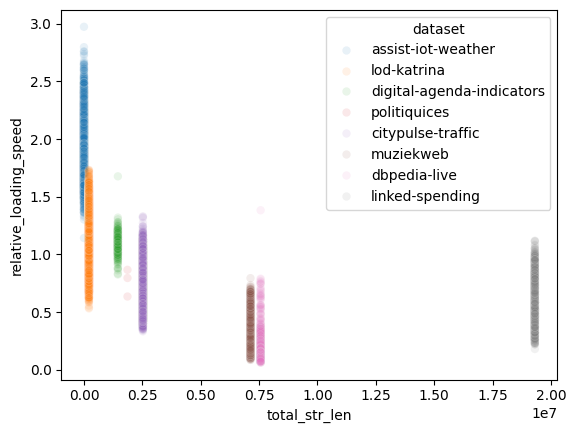

In [319]:
sns.scatterplot(
    data=tmp_df.sort_values(by='total_str_len'), 
    x='total_str_len',
    y='relative_loading_speed', hue='dataset', alpha=0.1)

<Axes: xlabel='log_total_str_len', ylabel='relative_loading_speed'>

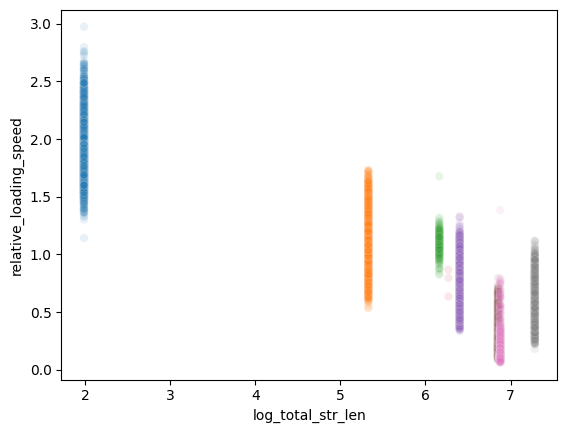

In [320]:
tmp_df['log_total_str_len'] = np.log10(tmp_df['total_str_len'])
sns.scatterplot(
    data=tmp_df.sort_values(by='total_str_len'), 
    x='log_total_str_len',
    y='relative_loading_speed', hue='dataset', alpha=0.1, legend=False)

### Feature Removal

At this point we will try to remove the most important features and see how the model behaves. MSE to compare to is `0.0019`.

In [156]:
X, y = get_training_data(df.drop(columns=['str_ratio']))

In [160]:
rf = RandomForestRegressor()
y_pred, predictions_df, mse = evaluate_model(rf, X)
print(f"MSE: {mse}")

MSE: 0.0019212279790712847


Somewhat surprsingly, the performance is as good as previously, what are the most important features?

In [163]:
rf = RandomForestRegressor(n_estimators=1000)
rf, importance_df = get_feature_importances(rf, X)
importance_df

,importance,relative
mean_str_len,0.691125,4.146752
batch,0.162198,0.973187
date_ratio,0.093083,0.558499
unique_subjects_count,0.046509,0.279051
mean_degree,0.004037,0.024220
numerical_ratio,0.003048,0.018291


`batch` is again quite high, as is to be expected. Now `mean_str_len` is the most imporant feature by far. Once again it's a feature connected to the nature of string literals in the graphs. `date_ratio` and `unique_subject_count` are also not that low. The former is twice as imporant as the latter and is inversly correlated with `str_ratio`.

Let's remove once again remove the most important feature as well as all ratios.

In [ ]:
X, y = get_training_data(df.drop(columns=['str_ratio', 'numerical_ratio', 'date_ratio', 'mean_str_len']))

In [170]:
rf = RandomForestRegressor()
y_pred, predictions_df, mse = evaluate_model(rf, X)
print(f"MSE: {mse}")

MSE: 0.001909933461949049


The performance is still as good and arguably even better, with only 3 attributes!

In [171]:
rf = RandomForestRegressor(n_estimators=1000)
rf, importance_df = get_feature_importances(rf, X)
importance_df

,importance,relative
unique_subjects_count,0.514611,1.543833
mean_degree,0.317293,0.951879
batch,0.168096,0.504288


This time `batch` is the least important feature of all, `unique_subjects_count` is still more important than `mean_degree`.

### Single Attribute Predictions

Since 3 attributes including `batch` seem to be performing quite well. Let's compare the MSE of predctions made using only one attribute + `batch`. However let's also use 10-fold cross validation.

In [ ]:
df = pd.merge(stats, time, on='dataset') # let's bring back the original dataset
attributes = df.drop(columns=['dataset', 'relative_loading_speed', 'batch']).columns
mses = []
for i, att in enumerate(attributes):
    print(f"fitting for {att}... ({i+1}/{len(attributes)})", end="", flush=True)
    X, y = get_training_data(df[[att, 'batch', 'relative_loading_speed', 'dataset']])

    rf = RandomForestRegressor()
    mse = -np.mean(cross_val_score(rf, X, y, cv=10, verbose=0, n_jobs=10))
    mses.append(mse)
    print(f"done! (mse={mse})")
mse_df = pd.DataFrame(index=attributes, data={'mse': mses})

In [229]:
mse_df.sort_values(by='mse')

,mse
str_count,0.266992
literal_object_ratio,0.269363
mean_str_len,0.293681
numerical_like_count,0.433682
numerical_ratio,0.646135
unique_objects_count,0.649137
str_ratio,0.728923
unique_subjects_count,1.706809
object_count,1.756390
entity_object_count,1.909428


The lowest MSE is achieved for `str_count`, `literal_object_ratio` and `mean_str_len` all of which are connected to the nature of strings in the graphs. Comparatively good results are also achieved for `numercal_` attributes but they are correlated with the former ones.

For attributes such as `literal_object_count` the model is completly hopeless.

One thing to note is that even the smallest MSE values are quite large, remember that for LinearRegression the value of MSE was 0.045 and the model was pretty poor even then. Just to make sure that the model isn't compeltely hopeless on when used with a testing dataset let's train and evaluate it on a 90/10 split.

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['dataset'])
ss = StandardScaler() 

X_train = df_train.drop(columns=["relative_loading_speed", "dataset"])
X_test = df_test.drop(columns=["relative_loading_speed", "dataset"])

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

y_train = df_train[["relative_loading_speed"]].values.flatten()
y_test = df_test[["relative_loading_speed"]].values.flatten()

0.014194340135338152


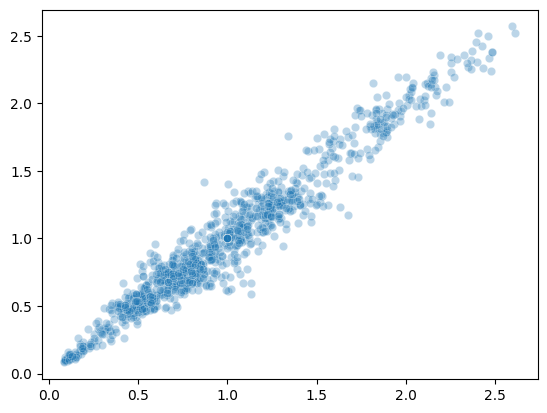

In [244]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
print(mean_squared_error(y_test, y_pred))

Using all attributes the MSE is much higher on the testing set, which is of course expected, but is still lower than what LinearRegression achieved on the training set alone. Looking at the plot, the model is still satisfactory albeit worse.

Of course, our objective is not to find a good model but to verify that the model did not overfit in our previous analyses and that the single attribute analysis is still valid.

### Conclusion of Milestone 1

In conclusion, based on our analysis it seems that the precense of strings as object is the most important factor in determining the loading speed of a dataset. All our experiments point towards features connected to this. Feature importances obtained using Random Forrest were consistently much higher than for other features and the single attribute fit was by far the most performant for those attributes as well all of which means that these attributes carry important information about the final loading speed. Visual analysis of correlation graphs also shows a clear trend between those attributes and the relative loading speed.